### Bibliotek

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

%reload_ext autoreload
%autoreload 2
from src import *

### Laste inn og gjennomsnittsberegne radiometriske kalibreringsbilder

In [139]:
#Data paths
notebook_dir = os.getcwd()

dark_paths_e50 = glob.glob(os.path.join(notebook_dir, 'Data', 'dark-images', 'E50', '*.bip'))  # Eksponering 50 ms
dark_paths_e100 = glob.glob(os.path.join(notebook_dir, 'Data', 'dark-images', 'E100', '*.bip'))  # Eksponering 100 ms
dark_paths_e300 = glob.glob(os.path.join(notebook_dir, 'Data', 'dark-images', 'E300', '*.bip'))  # Eksponering 300 ms
dark_paths_e450 = glob.glob(os.path.join(notebook_dir, 'Data', 'dark-images', 'E450', '*.bip'))  # Eksponering 450 ms
dark_paths_e500 = glob.glob(os.path.join(notebook_dir, 'Data', 'dark-images', 'E500', '*.bip'))  # Eksponering 500 ms
dark_paths_e1000 = glob.glob(os.path.join(notebook_dir, 'Data', 'dark-images', 'E1000', '*.bip'))  # Eksponering 1000 ms

B_measured_200W_E100_paths = glob.glob(os.path.join(notebook_dir, 'Data', 'MeasuredIntensity', '200W', 'E100', '*.bip'))  # 200W, Eksponering 100 ms
B_measured_200W_E500_paths = glob.glob(os.path.join(notebook_dir, 'Data', 'MeasuredIntensity', '200W', 'E500', '*.bip'))  # 200W, Eksponering 500 ms
B_measured_200W_E1000_paths = glob.glob(os.path.join(notebook_dir, 'Data', 'MeasuredIntensity', '200W', 'E1000', '*.bip'))  # 200W, Eksponering 1000 ms

B_measured_1000W_E100_paths = glob.glob(os.path.join(notebook_dir, 'Data', 'MeasuredIntensity', '1000W', 'E100', '*.bip'))  # 1000W, Eksponering 100 ms
B_measured_1000W_E300_paths = glob.glob(os.path.join(notebook_dir, 'Data', 'MeasuredIntensity', '1000W', 'E300', '*.bip'))  # 1000W, Eksponering 300 ms
B_measured_1000W_E450_paths = glob.glob(os.path.join(notebook_dir, 'Data', 'MeasuredIntensity', '1000W', 'E450', '*.bip'))  # 1000W, Eksponering 450 ms

## Calculate average images for each dataset and save them as .txt files (this is done only once)
utils.calculate_average_image(B_measured_200W_E100_paths, 'Data/Average/MeasuredData/B_200W_E100_avg.txt')
utils.calculate_average_image(B_measured_200W_E500_paths, 'Data/Average/MeasuredData/B_200W_E500_avg.txt')
utils.calculate_average_image(B_measured_200W_E1000_paths, 'Data/Average/MeasuredData/B_200W_E1000_avg.txt')

utils.calculate_average_image(dark_paths_e50, 'Data/Average/Noise/Dark_Image_E50_avg.txt')
utils.calculate_average_image(dark_paths_e100, 'Data/Average/Noise/Dark_Image_E100_avg.txt')
utils.calculate_average_image(dark_paths_e300, 'Data/Average/Noise/Dark_Image_E300_avg.txt')
utils.calculate_average_image(dark_paths_e450, 'Data/Average/Noise/Dark_Image_E450_avg.txt')
utils.calculate_average_image(dark_paths_e500, 'Data/Average/Noise/Dark_Image_E500_avg.txt')
utils.calculate_average_image(dark_paths_e1000, 'Data/Average/Noise/Dark_Image_E1000_avg.txt')

### Støy

All Data:
   Degree  RMS Error       c_0       c_1        c_2       c_3
0       1  4.910e-01 8.363e+00 1.454e-03        NaN       NaN
1       2  3.870e-01 7.874e+00 4.668e-03 -3.074e-06       NaN
2       3  3.589e-01 7.429e+00 1.163e-02 -2.228e-05 1.272e-08

Excluded E300 and E450:
   Degree  RMS Error       c_0       c_1        c_2       c_3
0       1  1.223e-02 8.035e+00 1.460e-03        NaN       NaN
1       2  4.069e-03 8.049e+00 1.331e-03  1.244e-07       NaN
2       3  2.665e-15 8.029e+00 1.687e-03 -8.090e-07 5.982e-10


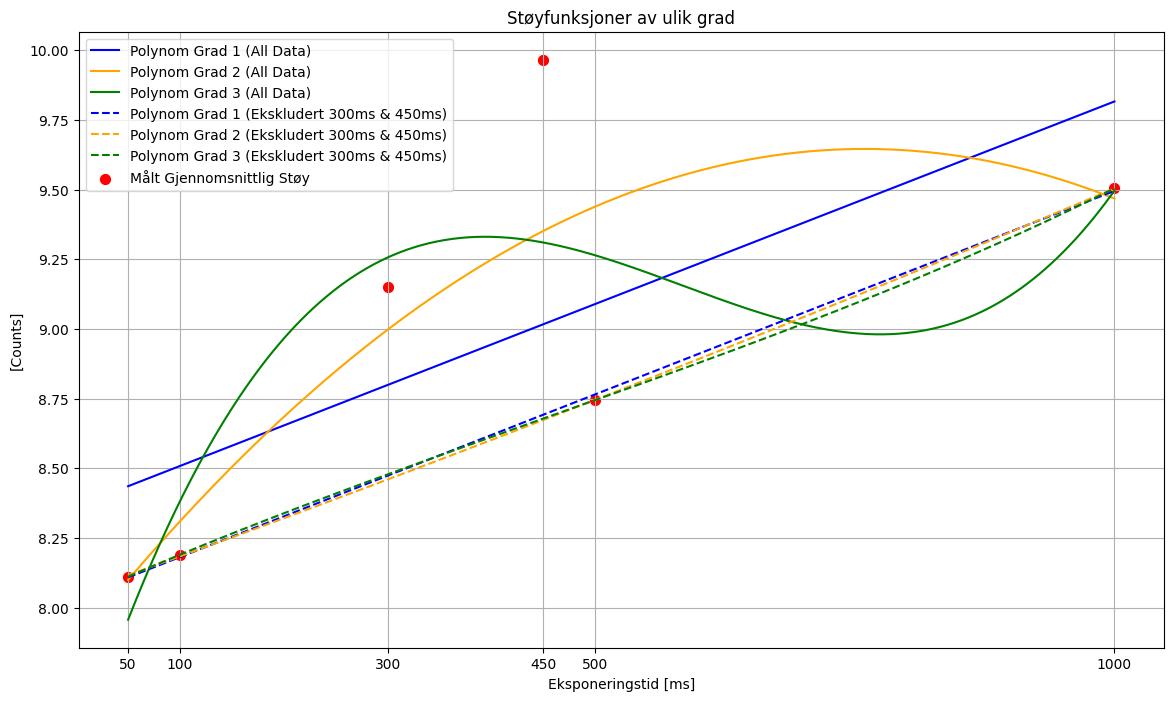

In [177]:
# Directory containing the dark images
directory = 'Data/Average/Noise/'

# Initialize lists to store exposure times and noise values
exposure_times = []
noise_values = []
mean_noise_values = []

# List all .txt files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        # Extract the exposure time from the filename
        # Example filename: Dark_Image_E100_avg.txt
        exposure_time_str = filename.split('_')[2].replace('E', '').replace('avg.txt', '')
        exposure_time = int(exposure_time_str)
        exposure_times.append(exposure_time)
        
        # Read the image data from the file
        file_path = os.path.join(directory, filename)
        image_data = np.loadtxt(file_path, delimiter=',')

        noise_values.append(image_data)

        # Calculate the mean noise (mean pixel value)
        mean_noise = np.mean(image_data)
        mean_noise_values.append(mean_noise)

# Convert lists to numpy arrays for plotting
exposure_times = np.array(exposure_times)
mean_noise_values = np.array(mean_noise_values)
noise_values = np.array(noise_values)

# Sort the data by exposure times
sorted_indices = np.argsort(exposure_times)
exposure_times = exposure_times[sorted_indices]
mean_noise_values = mean_noise_values[sorted_indices]
noise_values = noise_values[sorted_indices]

# Define degrees for polynomial fitting
degrees = range(1, 4)

def fit_polynomials(exposure_times, mean_noise_values, degrees):
    rms_errors = {}
    coefficients_dict = {}
    polynomials = {}

    for degree in degrees:
        # Perform the polynomial fit
        coefficients = np.polyfit(exposure_times, mean_noise_values, degree)
        coefficients_dict[degree] = coefficients[::-1]  # Reverse the order of coefficients
        
        # Store the polynomial
        polynomial = np.poly1d(coefficients)
        polynomials[degree] = polynomial
        
        # Predict the noise values using the polynomial
        predicted_noise = polynomial(exposure_times)
        
        # Calculate the RMS error
        rms_error = np.sqrt(np.mean((mean_noise_values - predicted_noise) ** 2))
        rms_errors[degree] = rms_error

    return rms_errors, coefficients_dict, polynomials

# Fit polynomials with all data
rms_errors_all, coefficients_dict_all, polynomials_all = fit_polynomials(exposure_times, mean_noise_values, degrees)

# Exclude E300 and E450 data
exclude_indices = np.where((exposure_times == 300) | (exposure_times == 450))[0]
exposure_times_excluded = np.delete(exposure_times, exclude_indices)
mean_noise_values_excluded = np.delete(mean_noise_values, exclude_indices)

# Fit polynomials with excluded data
rms_errors_excluded, coefficients_dict_excluded, polynomials_excluded = fit_polynomials(exposure_times_excluded, mean_noise_values_excluded, degrees)

# Create DataFrames to display the RMS errors and coefficients in tables
def create_dataframe(rms_errors, coefficients_dict, degrees):
    noise_df = pd.DataFrame({'Degree': list(rms_errors.keys()), 'RMS Error': list(rms_errors.values())})
    max_degree = max(degrees)
    for i in range(max_degree + 1):
        noise_df[f'c_{i}'] = noise_df['Degree'].apply(lambda deg: coefficients_dict[deg][i] if i < len(coefficients_dict[deg]) else np.nan)
    return noise_df

pd.options.display.float_format = '{:0.3e}'.format

# Create DataFrames with rounded values to 3 decimal places
noise_df_all = create_dataframe(rms_errors_all, coefficients_dict_all, degrees)
noise_df_excluded = create_dataframe(rms_errors_excluded, coefficients_dict_excluded, degrees)

print("All Data:")
print(noise_df_all)
print("\nExcluded E300 and E450:")
print(noise_df_excluded)


colors = {1: 'blue', 2: 'orange', 3: 'green'}

# Plot the noise as a function of exposure time
plt.figure(figsize=(14, 8))

# Plot the polynomial fits for all data
x_range = np.linspace(min(exposure_times), max(exposure_times), 500)
for degree, polynomial in polynomials_all.items():
    plt.plot(x_range, polynomial(x_range), label=f'Polynom Grad {degree} (All Data)', color=colors[degree])

# Plot the polynomial fits for excluded data
x_range_excluded = np.linspace(min(exposure_times_excluded), max(exposure_times_excluded), 500)
for degree, polynomial in polynomials_excluded.items():
    plt.plot(x_range_excluded, polynomial(x_range_excluded), '--', label=f'Polynom Grad {degree} (Ekskludert 300ms & 450ms)', color=colors[degree])

plt.scatter(exposure_times, mean_noise_values, marker='o', label='Målt Gjennomsnittlig Støy', color='red', s=50)

plt.xlabel('Eksponeringstid [ms]')
plt.ylabel('[Counts]')
plt.title('Støyfunksjoner av ulik grad')
plt.xticks(exposure_times)
plt.legend()
plt.grid(True)
plt.show()

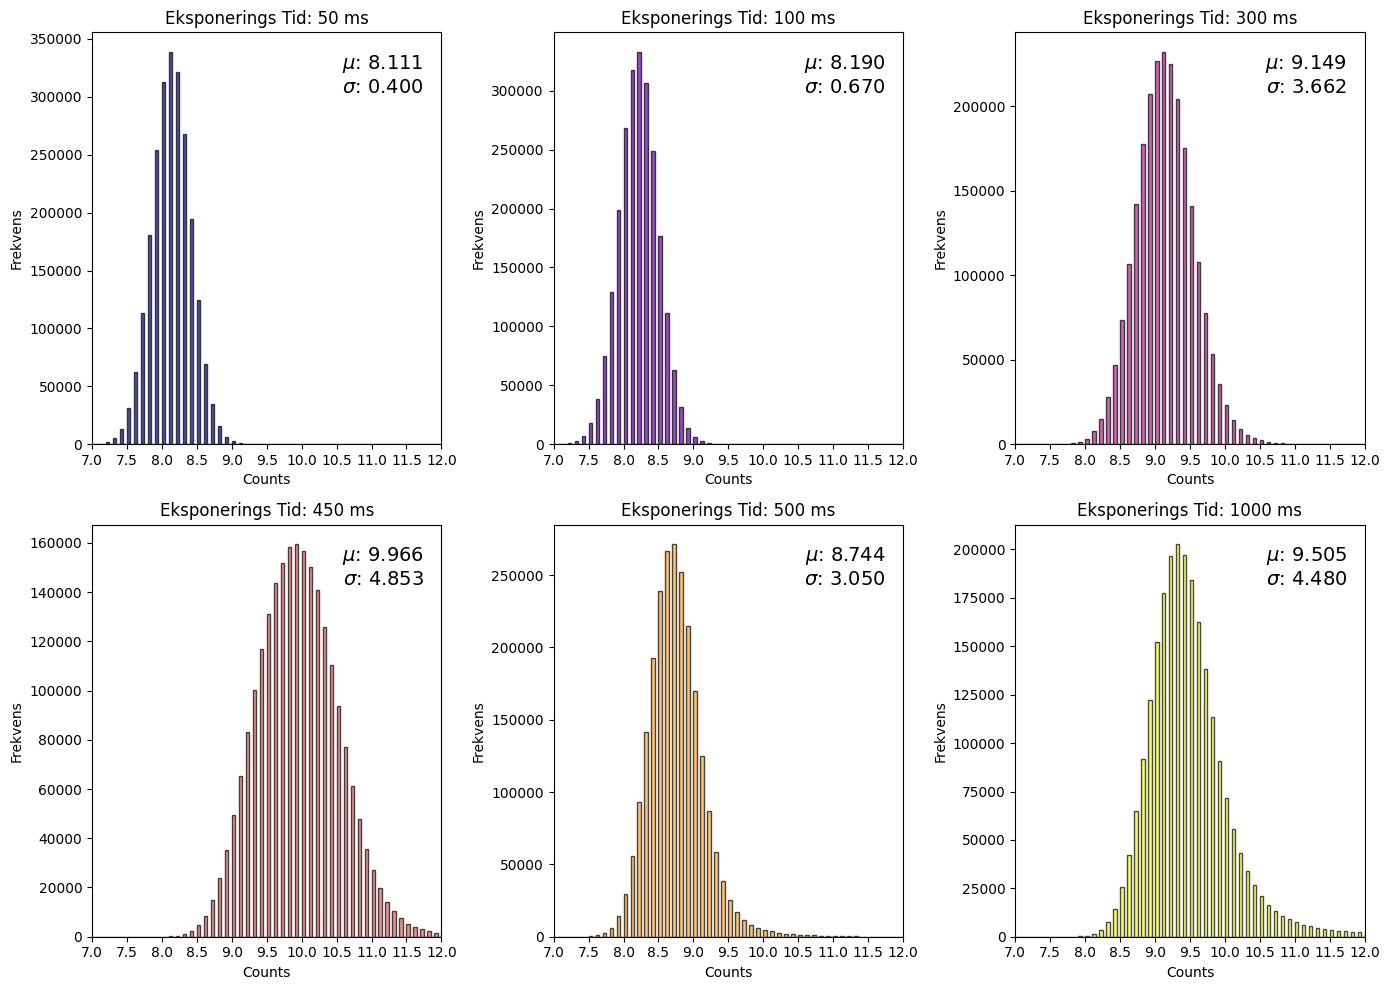

In [197]:
plt.figure(figsize=(14, 10))
num_images = len(noise_values)
num_cols = 3
num_rows = (num_images + num_cols - 1) // num_cols

range_min = 7
range_max = 12
bin_width = 0.05

colors = plt.cm.plasma(np.linspace(0, 1, len(noise_values)))

for i, (exposure_time, image_data) in enumerate(zip(exposure_times, noise_values)):
    plt.subplot(num_rows, num_cols, i + 1)
    # Calculate mean and standard deviation
    mean_value = np.mean(image_data)
    std_dev = np.std(image_data)
    
    # Use range parameter to only consider data within the specified range
    plt.hist(image_data.flatten(), bins=np.arange(range_min, range_max + bin_width, bin_width), 
             range=(range_min, range_max), alpha=0.7, color=colors[i], edgecolor='k')
    
    plt.title(f'Eksponerings Tid: {exposure_time} ms')
    plt.xlabel('Counts')
    plt.ylabel('Frekvens')
    plt.xlim(range_min, range_max)  # Focus x-axis on the range (6-12 counts)
    plt.xticks(np.arange(range_min, range_max+0.1, 0.5))  # Set x-ticks to integers
    # Add mean and standard deviation annotation
    plt.text(0.95, 0.95, rf'$\mu$: {mean_value:.3f}'+f'\n'+rf'$\sigma$: {std_dev:.3f}', 
             horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),fontsize=14)

plt.tight_layout()
plt.show()

### Tihi 2

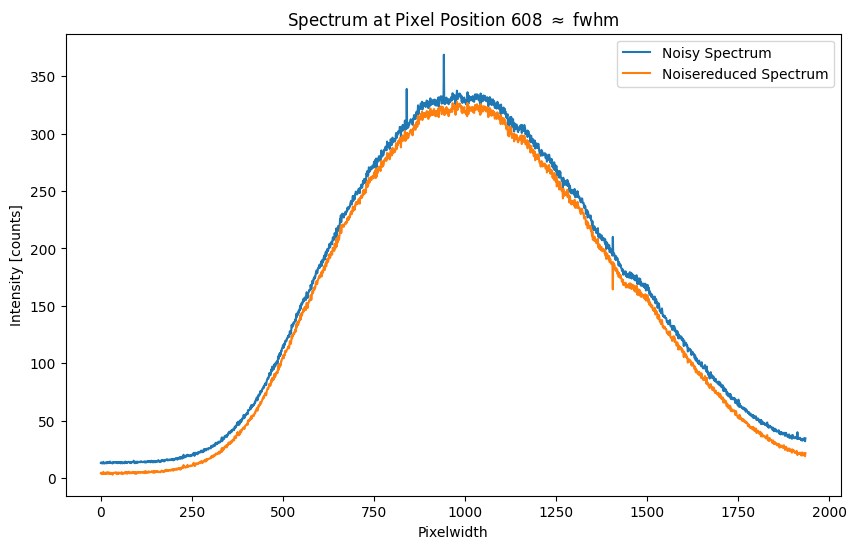

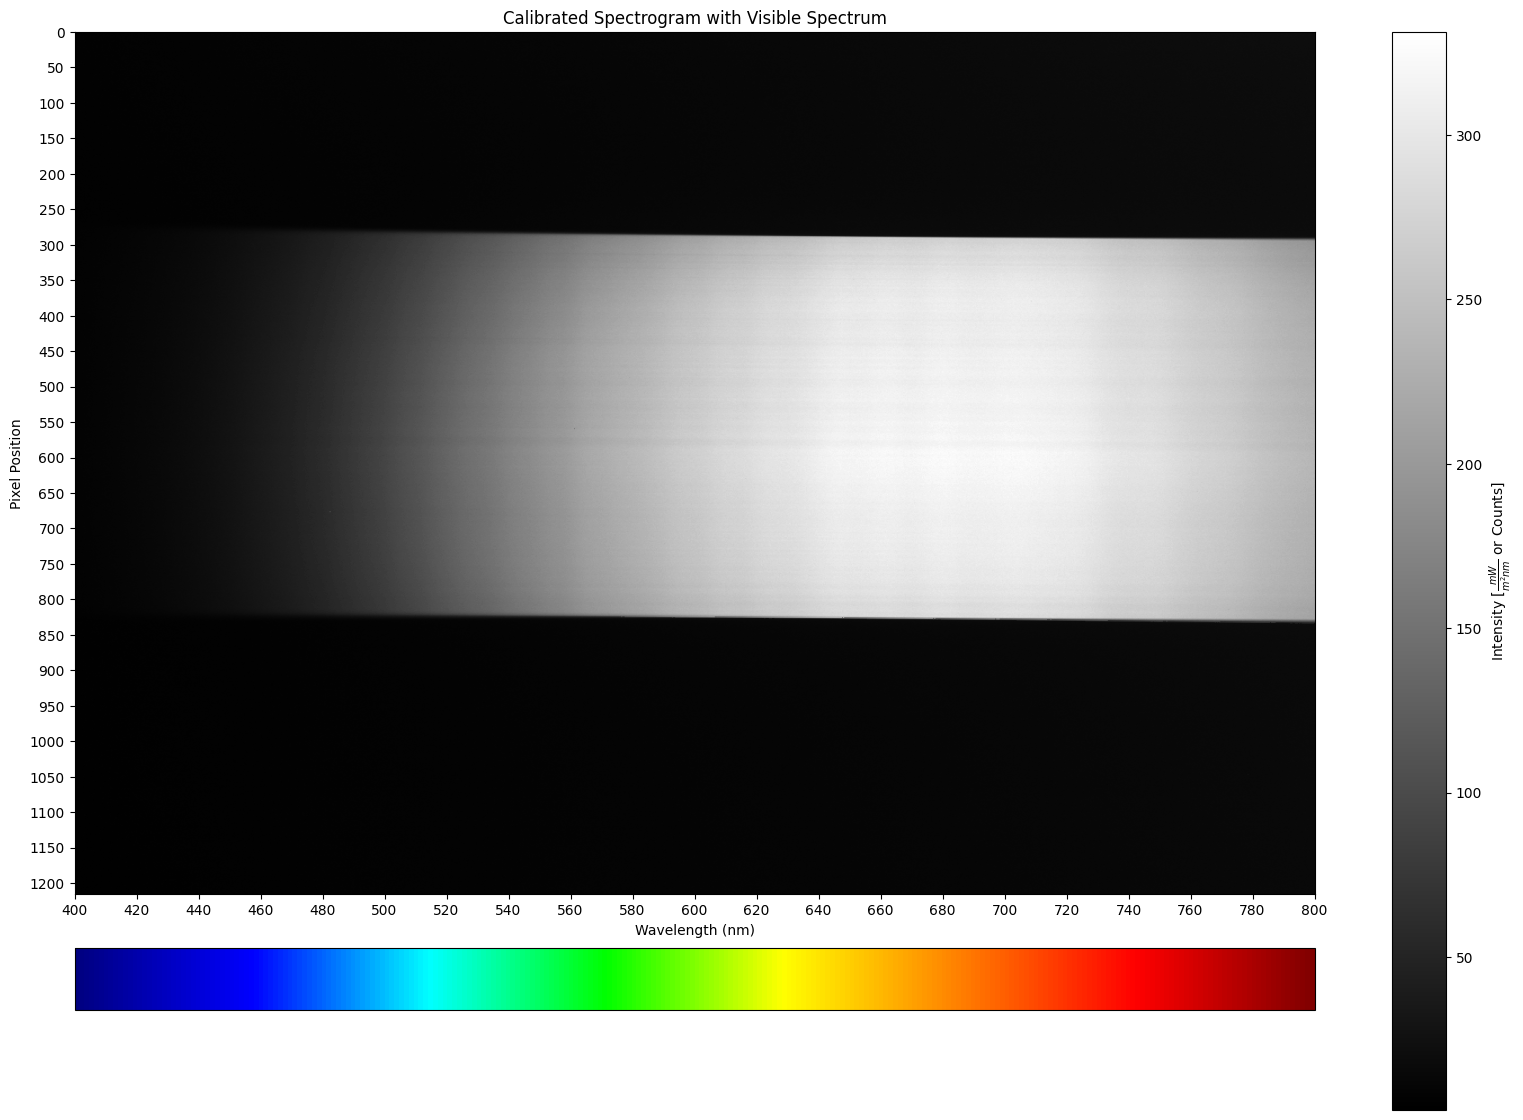

In [142]:
# Measured data
B = np.loadtxt('Data/Average/MeasuredData/B_200W_E1000_avg.txt', delimiter=',')
exposure_time = 1000

B_Noiseless = noiseFuncs.remove_noise(B, exposure_time) # Removes expected noise from the image depending on exposure time 

PixMid = 1216//2 

plt.figure(figsize=(10, 6))
plt.plot(B[PixMid,:], label='Noisy Spectrum')
plt.plot(B_Noiseless[PixMid,:], label='Noisereduced Spectrum')
plt.xlabel("Pixelwidth")
plt.ylabel('Intensity [counts]')
plt.title(rf'Spectrum at Pixel Position {PixMid} $\approx$ fwhm')
plt.legend()
plt.show()


spec, wave = calibration.pix_to_wavelength(B_Noiseless) # Convert pixel values to wavelength values

visualization.plot_visible_spectrum_cmap(spec, wave)

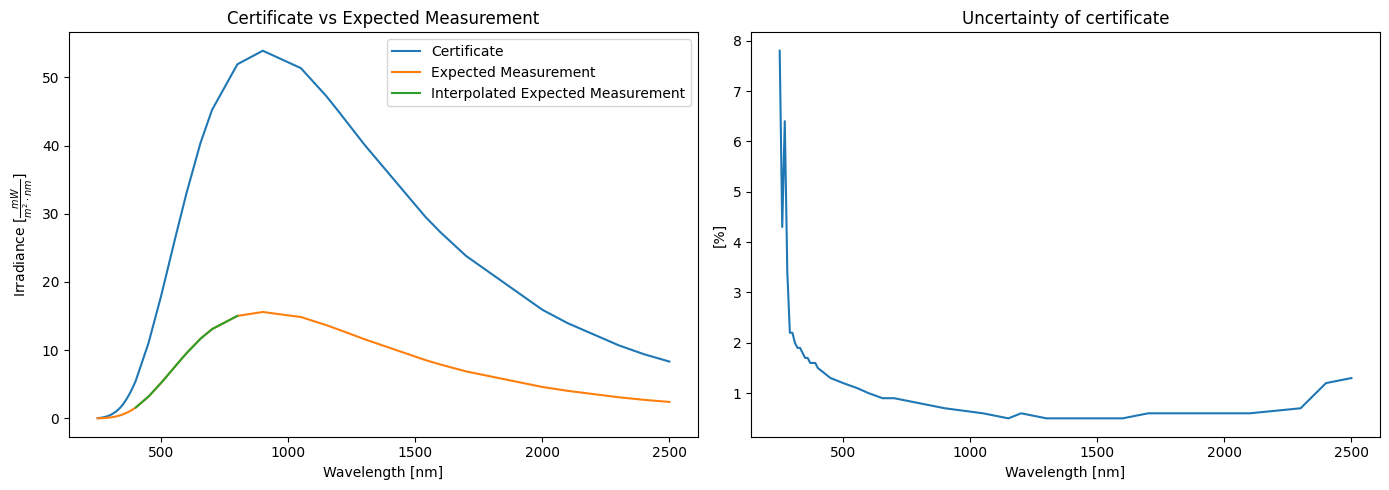

In [143]:
#Certificate data
W_L = np.loadtxt('Data/Calibrated/calibrationCertificate200W.txt', usecols=0) # Wavelengths in nm
B_0 = np.loadtxt('Data/Calibrated/calibrationCertificate200W.txt', usecols=1) # Irradiance in mW/m^2/nm
sigma = np.loadtxt('Data/Calibrated/calibrationCertificate200W.txt', usecols=2) # Uncertainty in %

# Interpolate the expected irradiance values to the same wavelengths as the measured data
B_expected, W_L = calibration.expected_irradiance()
B_interpolated = calibration.expected_irradiance(wave)

fig, (ax1, ax2) = plt.subplots(1,2 ,figsize=(14, 5))

# First subplot
ax1.plot(W_L, B_0, label='Certificate')
ax1.plot(W_L, B_expected, label='Expected Measurement')
ax1.plot(wave, B_interpolated, label='Interpolated Expected Measurement')
ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel(r'Irradiance [$\frac{mW}{m^2\cdot nm}$]')
ax1.legend()
ax1.set_title('Certificate vs Expected Measurement')

# Second subplot
ax2.plot(W_L, sigma)
ax2.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('[%]')
ax2.set_title('Uncertainty of certificate')

# Adjust layout
plt.tight_layout()
plt.show()


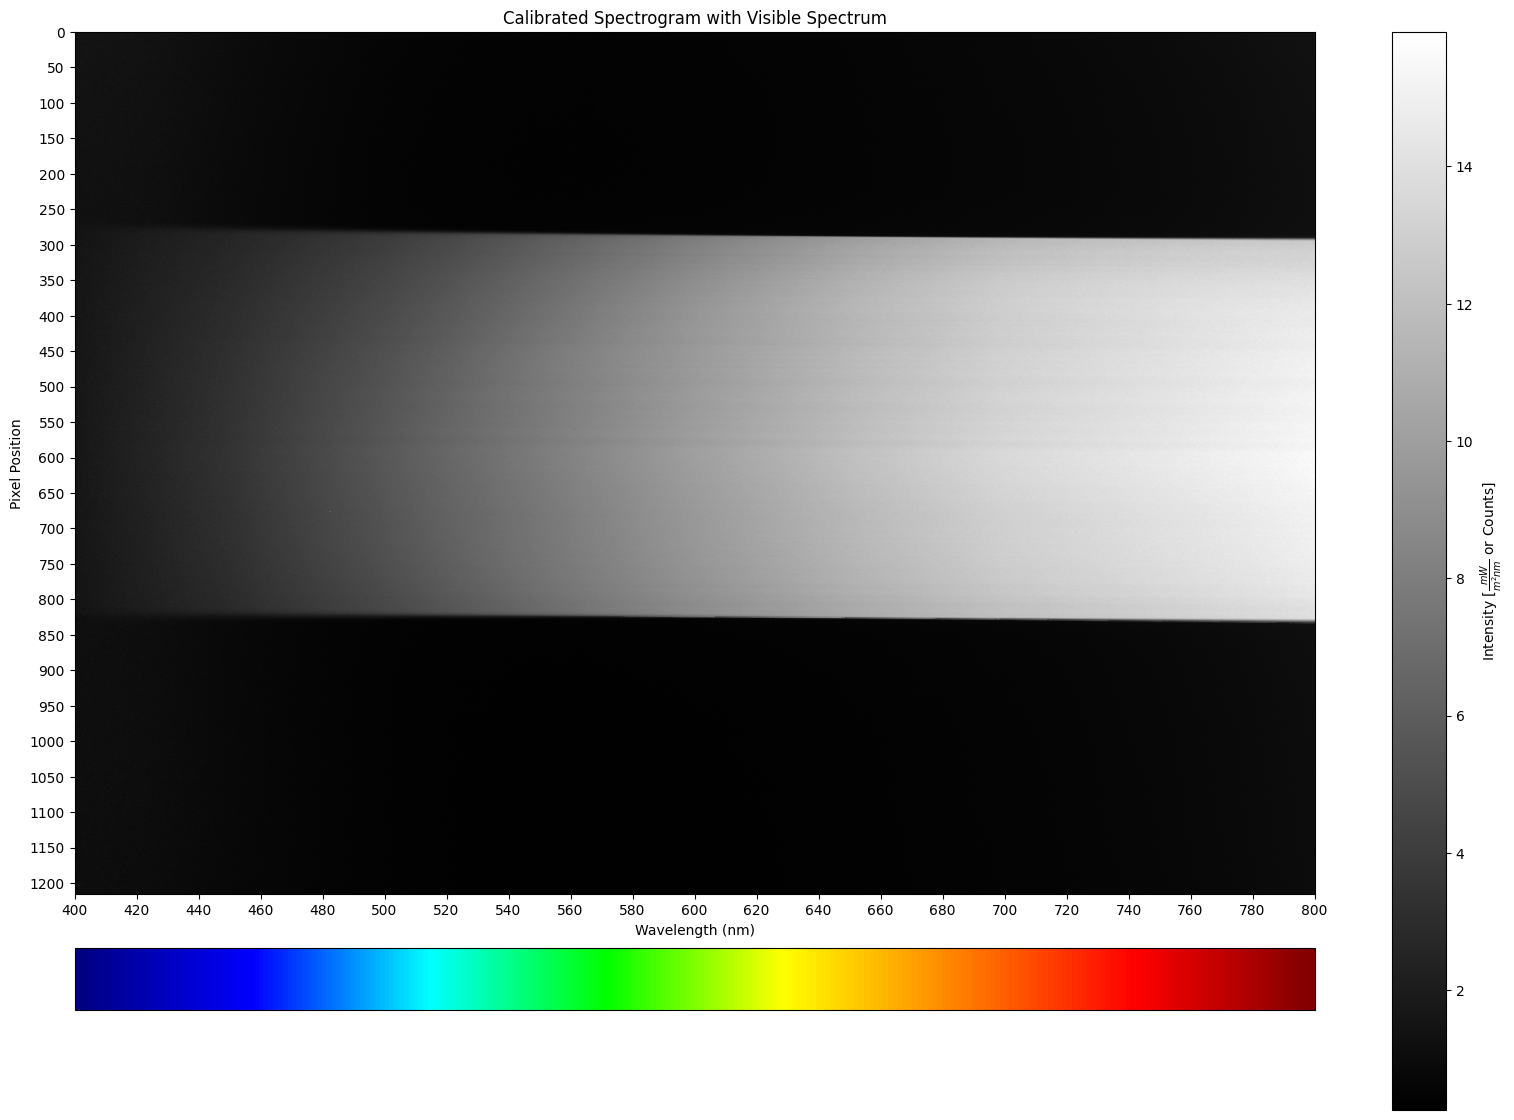

Text(0.5, 0, 'Wavelength')

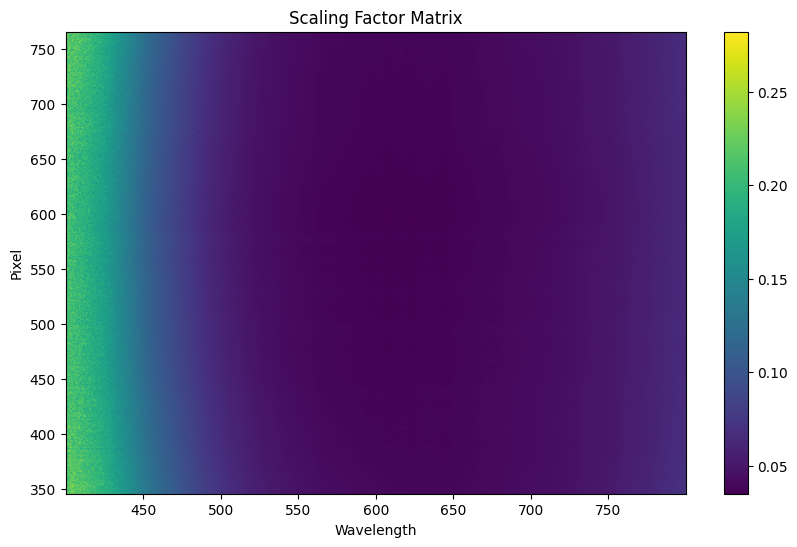

In [144]:
# Slice the array to get the desired range of rows
spec_slice = spec[346:766, :]

# Calculate the mean of each column within the specified range
row_means = np.mean(spec_slice, axis=0)

# Calculate scaling factor to transform counts to mW/m^2/nm and save to file
scaling_factor = B_interpolated / row_means
scaling_factor[np.isinf(scaling_factor)] = 0

k_matrix = B_interpolated / spec_slice

np.savetxt('Data/Calibrated/Scaling_Factor.txt', scaling_factor, delimiter=',')

visualization.plot_visible_spectrum_cmap(scaling_factor*spec, wave)

# 766 , 346
plt.figure(figsize=(10, 6))
extent = [wave.min(), wave.max(), 766, 346]
plt.imshow(k_matrix, aspect='auto', cmap='viridis',extent=extent)
plt.colorbar()
plt.title('Scaling Factor Matrix')
plt.ylabel('Pixel')
plt.gca().invert_yaxis()
plt.xlabel('Wavelength')

### Test

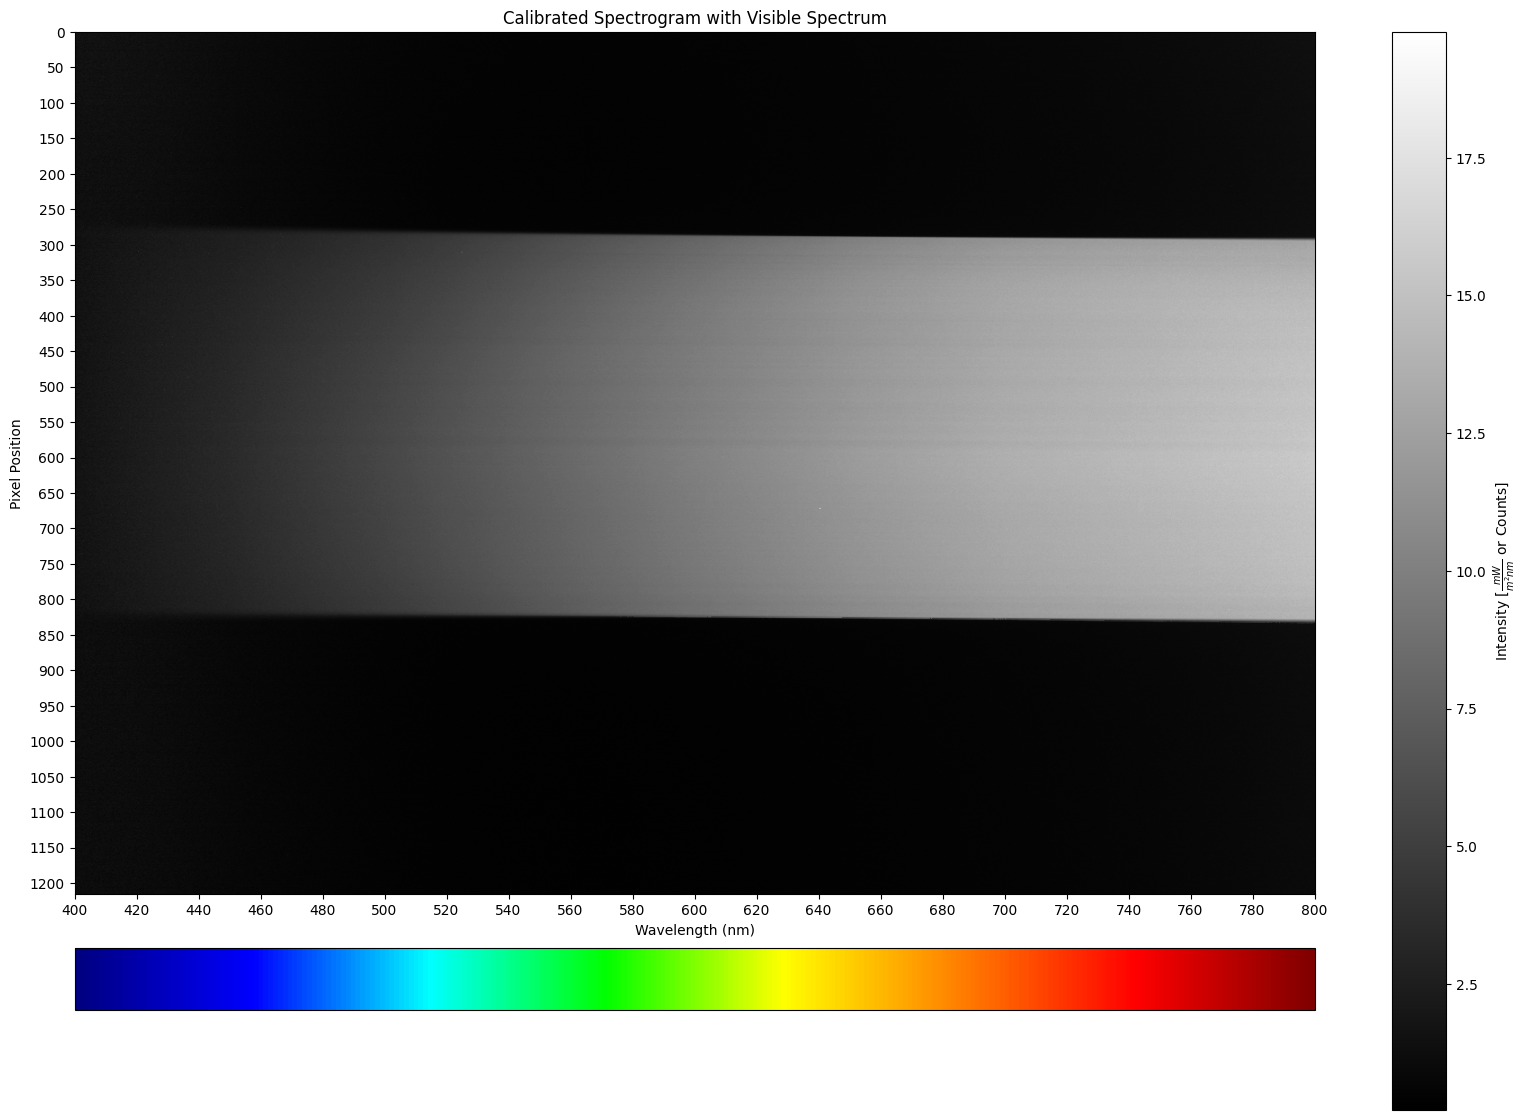

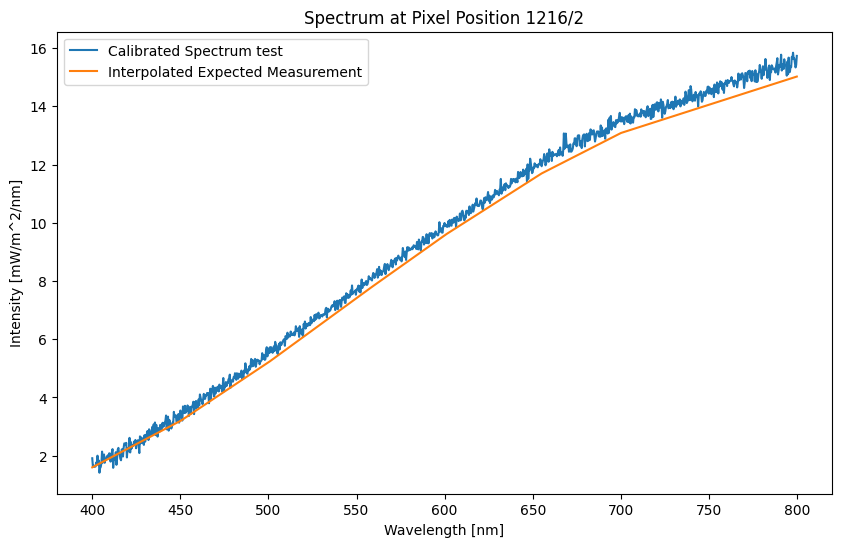

In [145]:
im = np.loadtxt('Data/Average/MeasuredData/B_200W_E500_avg.txt', delimiter=',')
exposure_time = 500

testSpec, testWave = calibration.full_calibration(im, exposure_time)

visualization.plot_visible_spectrum_cmap(testSpec, testWave)

plt.figure(figsize=(10, 6))
plt.plot(testWave, testSpec[1216//2,:], label='Calibrated Spectrum test')
plt.plot(wave, B_interpolated, label='Interpolated Expected Measurement')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity [mW/m^2/nm]')
plt.title('Spectrum at Pixel Position 1216/2')
plt.legend()
plt.show()

Error occurred: Data/Average/Noise/Dark_Image_E30_avg.txt not found.. Using expected mean noise instead.


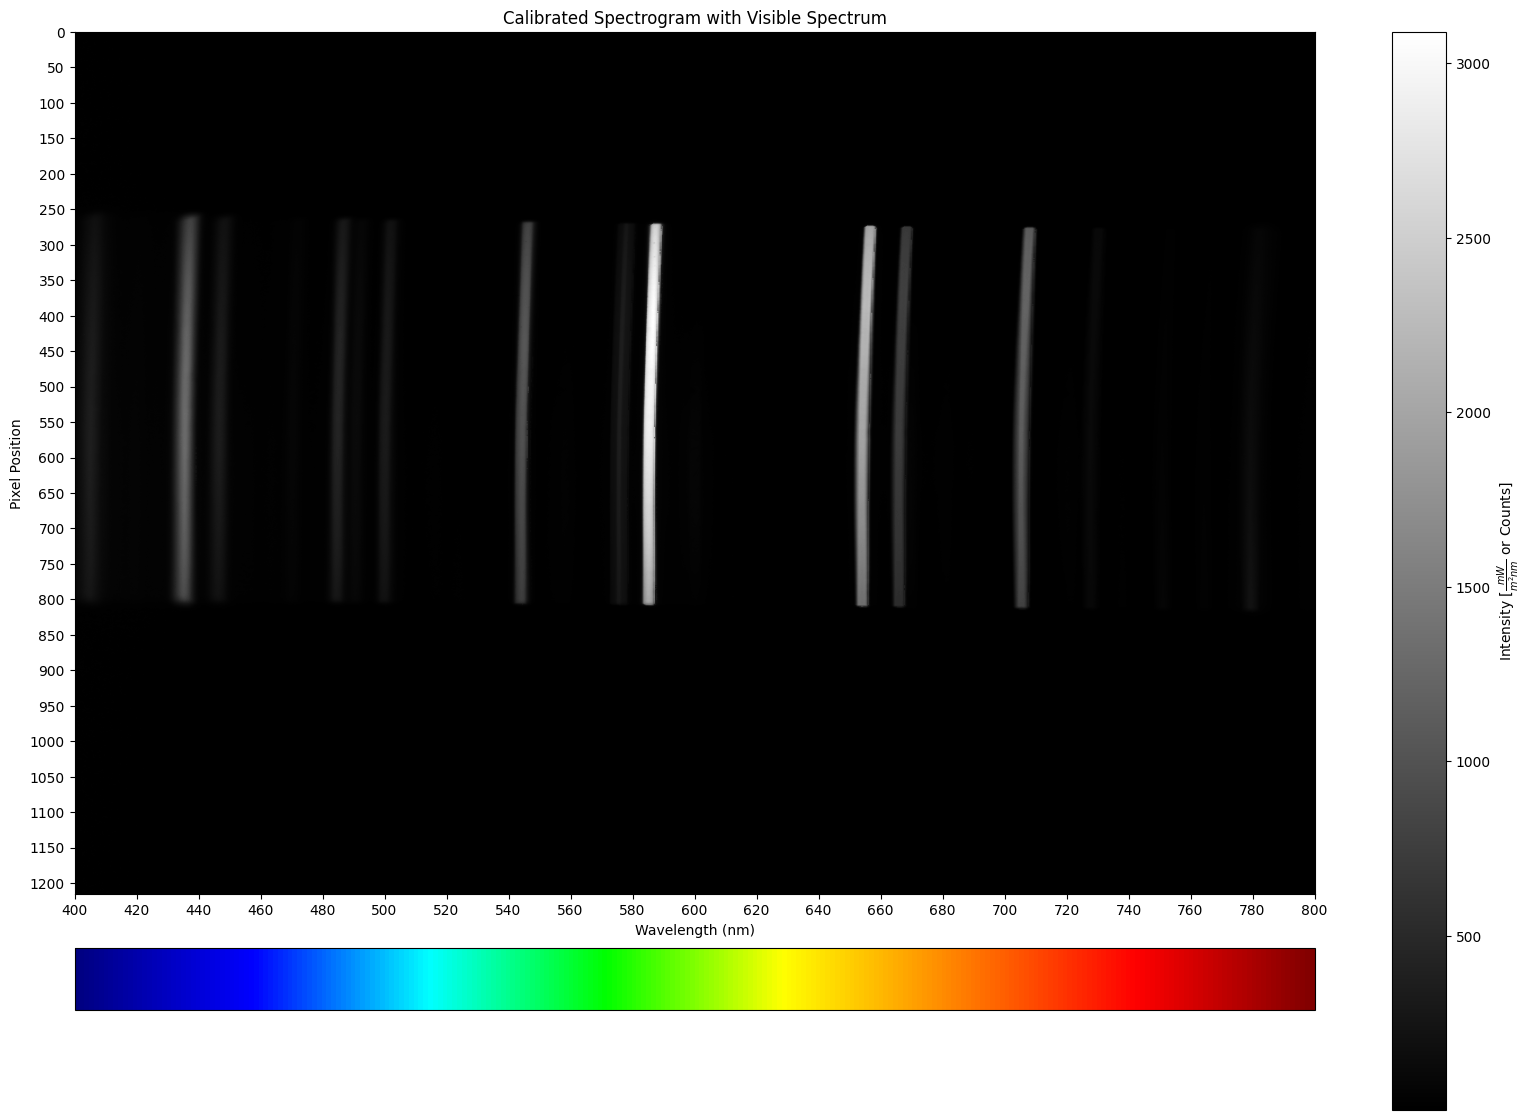

In [146]:
Hy = np.loadtxt('Data/Average/H_avg.txt', delimiter=',') # H exposure time = 50 ms, He exposure time = 30 ms, Hg exposure time = 100 ms
H_exposure = 50

He = np.loadtxt('Data/Average/He_avg.txt', delimiter=',')
He_exposure = 30

Hg = np.loadtxt('Data/Average/Hg_avg.txt', delimiter=',')
Hg_exposure = 100

HSpec, Wave = calibration.full_calibration(Hy, H_exposure)
HeSpec, Wave = calibration.full_calibration(He, He_exposure)
HgSpec, Wave = calibration.full_calibration(Hg, Hg_exposure)

GassSpec = HSpec+ HeSpec + HgSpec

visualization.plot_visible_spectrum_cmap(GassSpec, Wave)

Error occurred: Data/Average/Noise/Dark_Image_E49.9971_avg.txt not found.. Using expected mean noise instead.


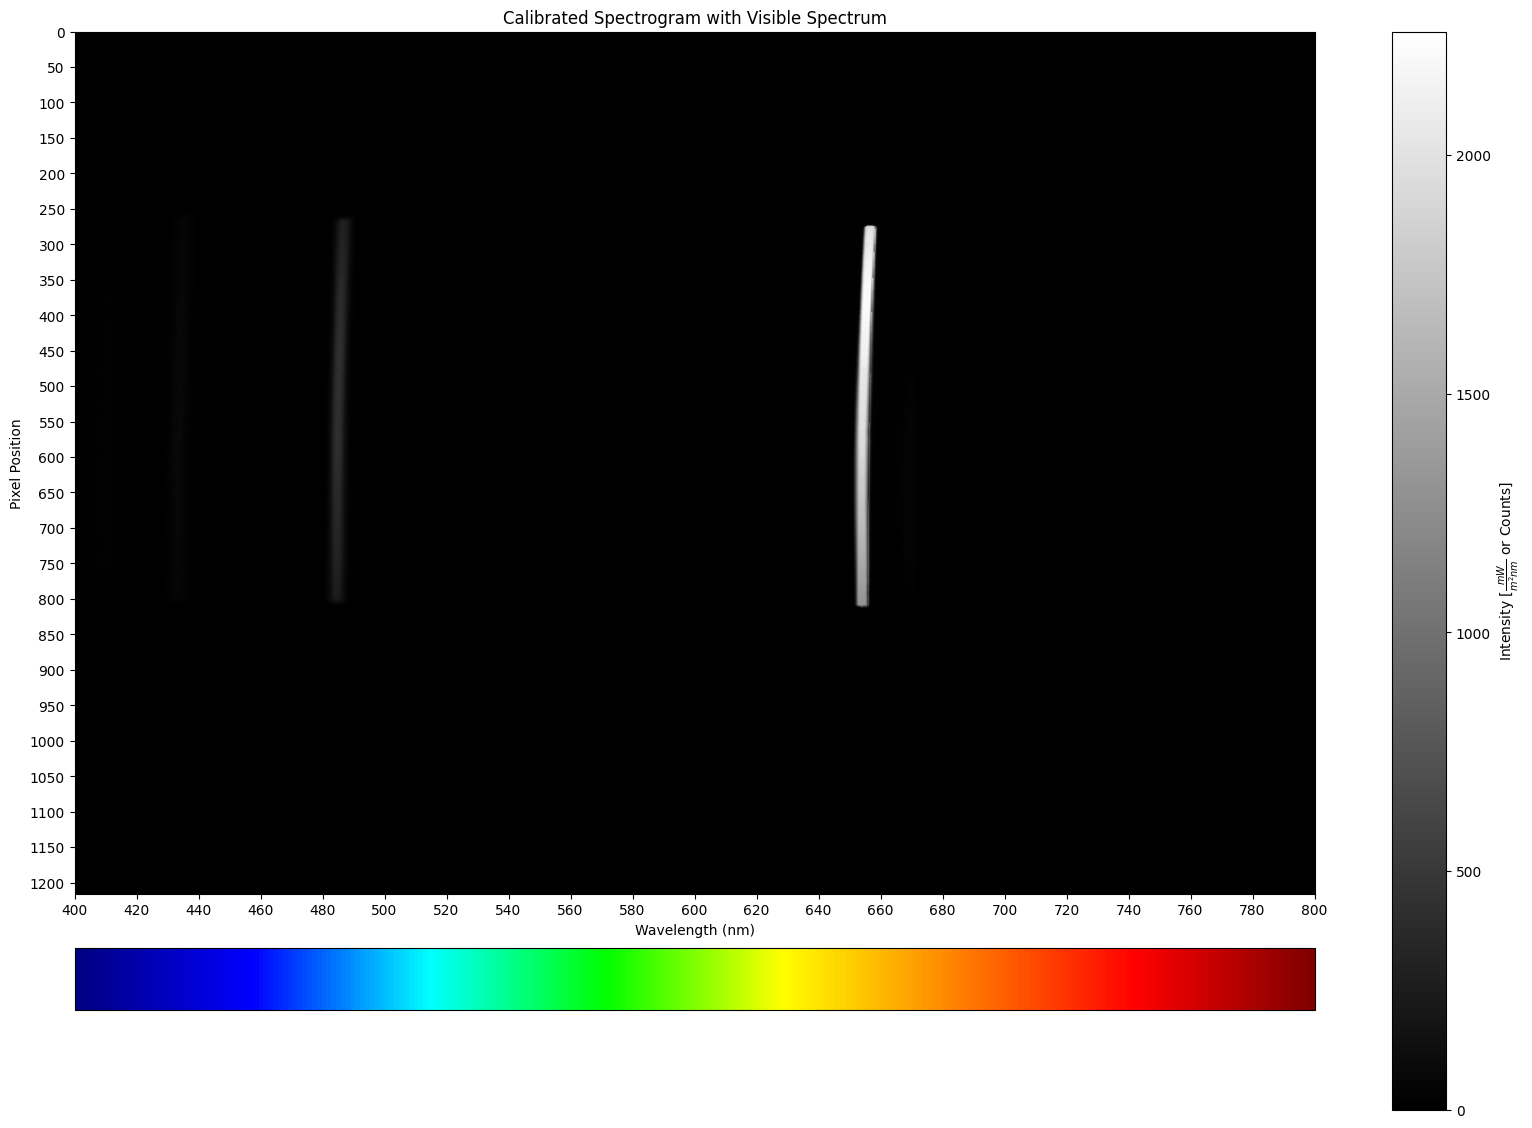

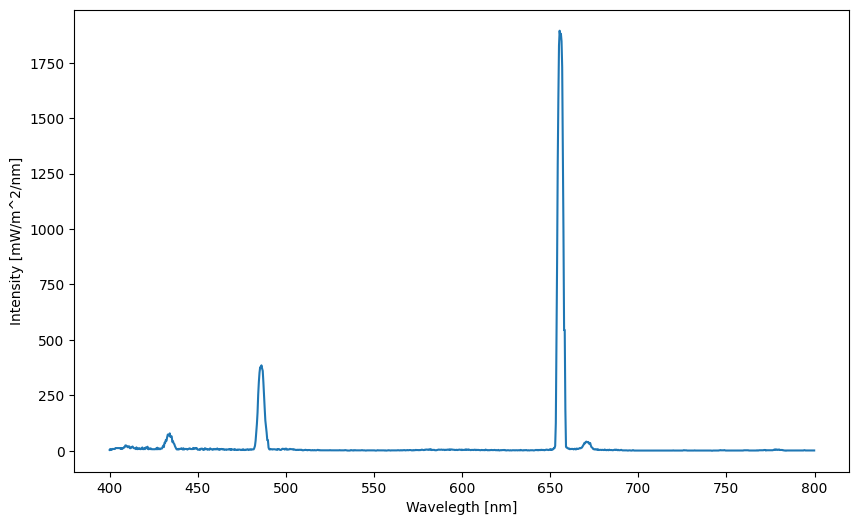

In [147]:
file_path = r'Data\H\1727181196.353_00000_e049.9971_g000_1936x1216.bip'

BipSpec, BipWave = calibration.bip_to_full_calibration(file_path)

plt.figure(figsize=(10, 6))
plt.plot(BipWave,BipSpec[1216//2,:])
plt.xlabel("Wavelegth [nm]")
plt.ylabel('Intensity [mW/m^2/nm]')
plt.show()